In [1]:
# Jesse Galef
# Using data scraped from C-SPAN's uncorrected closed caption transcripts


In [2]:
import pandas as pd
import numpy as np

In [3]:
import re

In [4]:
from bs4 import BeautifulSoup
import urllib

In [17]:
from scipy.sparse import csr_matrix, hstack, diags
from scipy.stats import skew, kurtosis

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.grid_search import GridSearchCV 
from sklearn.cross_validation import StratifiedKFold

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import SelectPercentile, SelectKBest, chi2, f_classif


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

In [8]:
# from spacy.en import English
# from spacy import attrs
# nlp_toolkit = English()
# # This does word POS much much faster than nltk's pos_tagger

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
# NLTK's sent_tokenize looks more accurate than Spacy's, and I only need to run it once
from nltk.corpus import stopwords
stops = list(stopwords.words('english'))

In [10]:
from textblob import TextBlob
# 

# Common Words Lists

In [11]:
conjunctions = [u'and',u'that',u'but',u'or',u'as',u'if',u'when',u'than',u'because',
                u'while',u'where',u'after',u'so',u'though',u'since',u'until',u'whether',
                u'before',u'although',u'nor',u'like',u'once',u'unless',u'now',u'except']

In [12]:
pronouns = [u"all", u"another", u"any", u"anybody", u"anyone", u"anything", u"both", u"each", u"each other",
            u"either", u"everybody", u"everyone", u"everything", u"few", u"he", u"her", u"hers",
            u"herself", u"him", u"himself", u"his", u"i", u"it", u"its", u"itself", u"little",
            u"many", u"me", u"mine", u"more", u"most", u"much", u"my", u"myself", u"neither", 
            u"no one", u"nobody", u"none", u"nothing", u"one", u"one another", u"other", u"others",
            u"our", u"ours", u"ourselves", u"several", u"she", u"some", u"somebody", u"someone",
            u"something", u"that", u"their", u"theirs", u"them", u"themselves", u"these", u"they",
            u"this", u"those", u"us", u"we", u"what", u"whatever", u"which", u"whichever", u"who",
            u"whoever", u"whom", u"whomever", u"whose", u"you", u"your", u"yours", u"yourself", u"yourselves"]

# Transformer classes and Functions

In [370]:

def pipeline_features(step):
    # Passed a pipeline or pipeline step, recursively checks each named 
    # step and builds a list of features.
    # This returns the list in the same order that the estimator uses
    # In retrospect, this is only useful when the pipeline is feature union, and 
    # took extra work to handle any true pipelines with one component feeding into another
    
    features = []
    if type(step)==Pipeline:
        for named_step in step.named_steps:
            features = features + pipeline_features(step.named_steps[named_step])
    elif type(step) == FeatureUnion:
        for transformer in step.transformer_list:
            features = features + pipeline_features(transformer[1])
    elif (type(step) == LogisticRegression or (type(step) == MultinomialNB)):
        features = []
    else:
        features = step.get_feature_names()
    return features


In [15]:
def pipeline_coef_df(pipeline):
    # Passed a pipeline with estimator, creates a DataFrame of the coeficients for each class
    
    feature_list = pipeline_features(pipeline)
    if len(pipeline.named_steps['classifier'].classes_) == 2:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = [pipeline.named_steps['classifier'].classes_[1]],
                           columns=feature_list).transpose()
        coef_df[pipeline.named_steps['classifier'].classes_[0]] = -coef_df[pipeline.named_steps['classifier'].classes_[1]]
    else:
        coef_df = pd.DataFrame(pipeline.named_steps['classifier'].coef_, 
                           index = pipeline.named_steps['classifier'].classes_, 
                           columns=feature_list).transpose()
    return np.e**(coef_df) # To get the odds ratios rather than the log odds


In [297]:
class word_length(TransformerMixin, BaseEstimator):
    # very quick calculation of the number ad distribution of words of different lengths
    
    def __init__(self):
#         self.min_length = min_length
#         self.max_length = max_length
#         self.bin_width = bin_width
        pass

    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        info = []
        for sentence in X:
            row = {}
            tokens = [len(t) for t in re.findall("\\b[\\w']+\\b", sentence)]
            row['avg_word_length'] = sum(tokens)/float(len(tokens))
#             row['word_length_skew'] = skew(tokens)
#             row['word_length_kurtosis'] = kurtosis(tokens)
            row['num_words'] = len(tokens)
            row['num_words_sqrt'] = len(tokens)**.5
            info.append(row)
        return pd.DataFrame(info)
    
    def get_feature_names(self):
        return ['avg_word_length', 'num_words', 'num_words_sqrt']
    

In [59]:
class best_vectorizer(TransformerMixin, BaseEstimator):
    # Transformer that takes a vectorizer and sklearn selector (like SelectKBest or SelectPercentile)
    # to find the n best features
    
    def __init__(self, vectorizer, selector, name):
        self.vectorizer=vectorizer
        self.selector=selector
        self.name = name
    
    def fit(self, X, y, **fit_params):
        vectors = self.vectorizer.fit_transform(X)
        self.selector.fit(vectors, y)
        return self

    def transform(self, X, **transform_params):
        return self.selector.transform(self.vectorizer.transform(X))
    
    def get_feature_names(self):
        return [self.name+feature for feature, used in zip(self.vectorizer.get_feature_names(), self.selector.get_support()) if used==True]
    
    

In [18]:


class sentiments(TransformerMixin, BaseEstimator):
    # Uses the Textblob library to evaluate the sentiment polarity & subjectivity of each sentence,
    # and returns the result of the passed vectorizer fit/transform multipied by polarity and subjectivity
    # For example, if a sentence is -.8 polarity and uses the term 'Obama', it will return 
    # -.8 as the value of polarity_obama
    
    # Returns csr sparse matrix
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
    
    def fit(self, X, y=None):
        self.vectorizer.fit(X)
        return self
    
    def transform(self, X):
        sent_vectors = self.vectorizer.transform(X)
        polarities = []
        subjectivities = []
        for sentence in X:
            polarity, subjectivity = TextBlob(sentence).sentiment
            polarities.append(polarity)
            subjectivities.append(subjectivity)
            
        p_diag = diags(polarities,0)
        s_diag = diags(subjectivities,0)
        polarity_vectors = p_diag.dot(sent_vectors)
        subjectivity_vectors = s_diag.dot(sent_vectors)
        return hstack([polarity_vectors,subjectivity_vectors])
    
    def get_feature_names(self):
        return ['polarity_'+i for i in self.vectorizer.get_feature_names()]+['subjectivity_'+i for i in self.vectorizer.get_feature_names()]


# Start reading data

In [19]:
republicans = ['Trump']#,'Cruz','Kasich','Rubio','Bush']
democrats = ['Clinton']#,'Sanders']
# Most of the infrastructure is here to include more than two candidates

long_df = pd.DataFrame()
for candidate in republicans+democrats:
    long_df = long_df.append(pd.read_csv(candidate+"_transcript_df.csv",index_col=0),ignore_index=True)

In [20]:
long_df.shape

(186, 6)

In [21]:
long_df.speaker.value_counts()

Trump      97
Clinton    89
Name: speaker, dtype: int64

In [22]:
regex_token_pattern = "\\b[\\w\']+\\b"

In [23]:
%%time
sentence_list = []
for idx, speech in long_df.iterrows():
    raw = unicode(speech.text,errors='ignore').lower().replace('  ',' ').replace('>','').replace('w3','').replace(' v ','')
    #Fixing a few known glitches in the C-SPAN transcribing service
    sentences = sent_tokenize(raw)
    for sentence in sentences:
        sent_info = {}
        sent_info['sentence'] = sentence
        sent_info['speaker'] = speech.speaker
        sent_info['date'] = speech.date
        sent_info['title'] = speech.title
        sent_info['speech_idx'] = idx
        sent_info['tokens'] = len(re.findall(regex_token_pattern, sentence))
        sentence_list.append(sent_info)
raw_df = pd.DataFrame(sentence_list)

CPU times: user 9.46 s, sys: 331 ms, total: 9.79 s
Wall time: 9.86 s


In [24]:
raw_df.speaker.value_counts()

Trump      41131
Clinton    17649
Name: speaker, dtype: int64

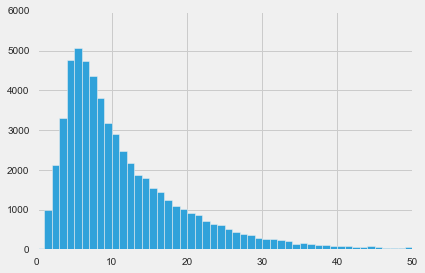

In [44]:
raw_df[raw_df.tokens <=50].tokens.hist(bins=50)
# plt.xlim([0,50])

In [26]:
declarations = {}
declarations['Trump'] = '2015-06-16'
declarations['Clinton'] = '2015-04-11'
# Although C-SPAN has the campaign tag, I want to make sure only to include
# events from after the candidates officially declared they were running for President

In [27]:

for i in range(20):
    print i, len(raw_df[raw_df.tokens>=i])/float(len(raw_df))

0 1.0
1 0.999574685267
2 0.982562095951
3 0.946410343654
4 0.89004763525
5 0.808863559034
6 0.722796869684
7 0.642191221504
8 0.567897243961
9 0.502926165362
10 0.448962232052
11 0.399387546785
12 0.357383463763
13 0.320125893161
14 0.288091187479
15 0.257281388227
16 0.230945899966
17 0.20646478394
18 0.185284110242
19 0.166468186458


In order to avoid sentences like "Thank you." which are indistinguishable, I'm only using
sentences with a certain number of tokens. 
Sometimes the uncorrected transcripts include long run-on sentences and song lyrics, so I'm also ignoring any sentences with more than 150 words.

In [459]:
min_length = 9
max_length = 150
df = raw_df[raw_df.tokens >= min_length]
df = df[df.tokens <= max_length]
post_dec = [date > dec for date,dec in zip(df.date, [declarations[candidate] for candidate in df.speaker])]
df = df[post_dec]

In [460]:
df.speaker.value_counts()

Trump      17294
Clinton    11977
Name: speaker, dtype: int64

In [262]:
max(df.speaker.value_counts())/float(len(df))

0.59082368214273517

# Data In, configure Pipeline

In [390]:
from sklearn.neural_network import BernoulliRBM
#  class sklearn.neural_network.BernoulliRBM(n_components=256, 
# learning_rate=0.1, batch_size=10, n_iter=10, verbose=0, 
# random_state=None)[source]¶

In [391]:
from sklearn.feature_selection import SelectFromModel
vectorizer = CountVectorizer(
#                          max_features = 7000,
                         ngram_range=(1,3), 
#                          stop_words='english',
                         decode_error='ignore',
#                          min_df = 1,
                         binary=True,
                        token_pattern = regex_token_pattern,
                            )

all_features = [
    
    ]
    
    

In [478]:
pipeline = Pipeline([
  ('features', FeatureUnion([
                    ('word_lengths', word_length()),
                    ('top_words', best_vectorizer(vectorizer, selector=SelectFromModel(estimator=LogisticRegression(penalty='l1', C=3)), name='')),
                ])),
    ('classifier', LogisticRegression(C=1,class_weight = 'balanced'))]
)

# Cross Validate to set hyperparameters

In [191]:
which_candidates = ['Clinton','Trump']

In [95]:
from sklearn.cross_validation import cross_val_score
import time

In [96]:
#  class sklearn.linear_model.LogisticRegression(penalty='l2', dual=False, 
# tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
# random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', verbose=0, 
# warm_start=False, n_jobs=1)[source]

In [479]:
t0=time.time()

condition = [speaker in which_candidates for speaker in df.speaker]
cand_df = df[condition]
kf = StratifiedKFold(y=cand_df.speaker, n_folds=3,random_state=42)
params = {'classifier__C': [.3,1,3],
#           'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
#           'features__top_words__vectorizer__min_df': [1,5],
#           'features__top_words__vectorizer__max_df': [.5,.25],
#           'features__top_words__selector__estimator__penalty': ['l1','l2],
#           'features__top_words__vectorizer__binary': [True, False],
          'features__top_words__selector__estimator__C': [1,3,10,30],
         }

grid = GridSearchCV(estimator=pipeline, param_grid = params, scoring = 'roc_auc',cv=kf, verbose=2)

grid.fit(cand_df.sentence,[1 if speaker == 'Trump' else 0 for speaker in cand_df.speaker])
print time.time()-t0

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=1 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=1 -  10.1s
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=1 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=1 -  10.3s
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=1 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=1 -  10.2s
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=3 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=3 -  10.4s
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=3 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=3 -  11.3s
[CV] classifier__C=0.3, features__top_words__selector__estimator__C=3 
[CV]  classifier__C=0.3, features__top_words__selector__estimator__C=3 -  10.9s
[CV] classifier__C=0.3, features_

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  6.3min finished


391.363381863


In [480]:
scores = grid.grid_scores_
grid.best_params_

{'classifier__C': 1, 'features__top_words__selector__estimator__C': 30}

In [481]:
cv = []
scores = grid.grid_scores_
for combo in scores:
    pars = combo[0]
    pars['mean'] = combo[1]
    cv.append(pars)
pd.DataFrame(cv).sort_values(by='mean',ascending=False)

,classifier__C,features__top_words__selector__estimator__C,mean
7,1.0,30,0.895484
3,0.3,30,0.895098
6,1.0,10,0.894864
2,0.3,10,0.894547
1,0.3,3,0.894461
5,1.0,3,0.894282
11,3.0,30,0.893711
0,0.3,1,0.893139
10,3.0,10,0.893036
4,1.0,1,0.892287


## Build a cross-val-predict-proba

In [482]:
pipeline=grid.best_estimator_

In [483]:
import time

cand_df = df[[speaker in which_candidates for speaker in df.speaker]]

n_folds = 20

segment_results = pd.DataFrame()
all_results = pd.DataFrame()
segment_coefs = [pd.DataFrame()]*n_folds

kf = StratifiedKFold(y=cand_df.speaker, n_folds =n_folds,random_state=42)

for i, (train_index, test_index) in enumerate(kf):
    t0 = time.time()
    pipeline.fit(cand_df.iloc[train_index].sentence, cand_df.iloc[train_index].speaker)
#     print 'done fitting',i,"time:",time.time()-t0
    segment_coefs[i] = pipeline_coef_df(pipeline)
    segment_results = pd.DataFrame(
                                    pipeline.predict_proba(cand_df.iloc[test_index].sentence),
                                    index=list(cand_df.iloc[test_index].index),
                                    columns=pipeline.named_steps['classifier'].classes_)
    print 'done predicting',i,"time:",time.time()-t0

    all_results=all_results.append(segment_results)
        
    

done predicting 0 time: 16.8037140369
done predicting 1 time: 15.7655580044
done predicting 2 time: 17.429459095
done predicting 3 time: 16.9800040722
done predicting 4 time: 18.5062031746
done predicting 5 time: 16.1421182156
done predicting 6 time: 15.0999100208
done predicting 7 time: 15.6903159618
done predicting 8 time: 16.6711018085
done predicting 9 time: 16.3370630741
done predicting 10 time: 14.66375494
done predicting 11 time: 15.0750689507
done predicting 12 time: 15.6643211842
done predicting 13 time: 15.9104609489
done predicting 14 time: 14.7660620213
done predicting 15 time: 15.0031490326
done predicting 16 time: 15.6732540131
done predicting 17 time: 15.1620569229
done predicting 18 time: 15.4064018726
done predicting 19 time: 15.1598138809


In [484]:
cv_result = cand_df.copy().join(all_results)

In [485]:
cv_result.groupby('speaker').mean()

,speech_idx,tokens,Clinton,Trump
speaker,,,,
Clinton,141.302329,19.623027,0.781201,0.218799
Trump,47.992541,16.334856,0.181493,0.818507


In [486]:
cv_result['predict'] = cv_result.apply(lambda x: x[which_candidates].argmax(), axis = 1)

In [487]:
cv_result['correct'] = cv_result.predict == cv_result.speaker

In [488]:
cv_result.correct.value_counts()

True     24941
False     4330
Name: correct, dtype: int64

In [489]:
cv_result.correct.mean()

0.85207201667179122

0.926223458981


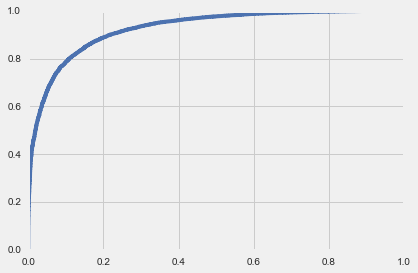

In [490]:
#  sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate
correct= [1 if speaker == 'Trump' else 0 for speaker in cv_result.speaker]
roc = roc_curve(correct, y_score=list(cv_result.Trump))
print roc_auc_score(correct, cv_result.Trump)
plt.plot(roc[0], roc[1])

In [491]:
sns.set_palette('deep')

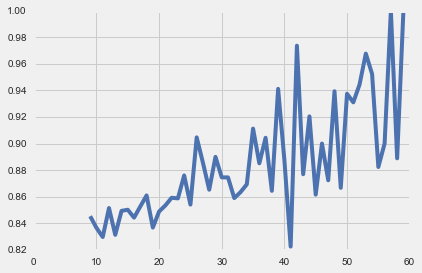

In [492]:
plt.plot(cv_result[(cv_result.tokens <=60)&(cv_result.tokens >=2)].groupby('tokens').mean()['correct'])

In [493]:
cv_result.head()

,date,sentence,speaker,speech_idx,title,tokens,Clinton,Trump,predict,correct
10,2016-09-03,i just wrote this the other day knowing that i...,Trump,1,Presidential Candidate Donald Trump Remarks in...,42,0.010040,0.989960,Trump,True
11,2016-09-03,"for centuries, the african american church has...",Trump,1,Presidential Candidate Donald Trump Remarks in...,15,0.123997,0.876003,Trump,True
12,2016-09-03,it is from the pews and pulpits and christian ...,Trump,1,Presidential Candidate Donald Trump Remarks in...,58,0.219244,0.780756,Trump,True
13,2016-09-03,and we are bound together and i see that today.,Trump,1,Presidential Candidate Donald Trump Remarks in...,10,0.322424,0.677576,Trump,True
15,2016-09-03,the african-american fate immunity has been on...,Trump,1,Presidential Candidate Donald Trump Remarks in...,18,0.409404,0.590596,Trump,True


In [494]:

for candidate in which_candidates:
    print "Most",candidate,":"
    for idx, row in cv_result[cv_result.speaker == cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print
    

Most Clinton :
	I hope you will join me and that you will be part of this effort to build on the progress we have made under president obama to go further and to make it absolutely clear that we are fighting to break down barriers wherever they may be because we know america deserves nothing less and americans deserve to have the future that we will create together.
-- 138 Presidential Candidate Hillary Clinton Rally in Orangeburg, South Carolina
http://www.c-span.org/video/?405395-1/hillary-clinton-campaign-rally-orangeburg-south-carolina
Predicted Clinton:  0.999999999994
Predicted Trump:  5.70171905237e-12

	I do not think president obama gets the credit he deserves for saving our economy from what could have been an even worse crisis, saving the auto industry, cracking down on wall street abuses which the bush administration had been ignoring, and passing the affordable care act which now provides health insurance to 18 million americans!
-- 164 Presidential Candidate Hillary Clint

In [595]:
cv_result.sort_values('Trump', inplace=True)

In [596]:
cv_result.to_csv('cv_result_sept_20.csv')
cv_result.to_csv('cv_result.csv')

In [496]:

for candidate in which_candidates:
    print "Most",candidate+"-like, but not:"
    for idx, row in cv_result[cv_result.speaker != cv_result.predict].sort_values(by=candidate,ascending=False).iloc[0:10].iterrows():
        sent = row.sentence
        print "\t",sent[0].upper()+sent[1:]
        print "--",row.speech_idx, row.title
        print long_df.loc[row.speech_idx].link
        print "Predicted Clinton: ",row.Clinton
        print "Predicted Trump: ",row.Trump
        print
    print
    print

Most Clinton-like, but not:
	Iwasatameetingwith55or60pastorsandministers.letmeaskyouaquestion.howmanychristiansareinthiscountry?theyfigured260millionpeople.asapoliticalblocthatisbiggerthanwomenandisbiggerthanmen.whyisitthatwegetpushedaround?imadethestatementaboutmuslims.isaidwehavetodosomethingtemporarilytofindoutwhatisgoingon.wecan'tletthesyrianscomein,wedon'tknowwhotheyare.wedon'tknowwheretheycomefrom.
-- 55 Donald Trump Campaign Rally in Valdosta, Georgia
http://www.c-span.org/video/?405478-1/donald-trump-campaign-rally-valdosta-georgia
Predicted Clinton:  0.999999296032
Predicted Trump:  7.03967975205e-07

	This is why we have already  passed legislation to support  wounded warriors, veterans who  struggle with mental health challenges and earlier this week to support female veterans in  particular who need our help.
-- 22 Faith and Freedom Coalition Conference
http://www.c-span.org/video/?410912-1/faith-freedom-coalition-holds-annual-conference
Predicted Clinton:  0.999995902061
P

In [497]:
sums = {}
for candidate in which_candidates:
    sums[candidate] = pd.DataFrame(index=segment_coefs[0].index)
t0 = time.time()
for i, segment in enumerate(segment_coefs):
    segment.drop_duplicates(inplace=True)
    for candidate in which_candidates:
        sums[candidate] = sums[candidate].join(segment[candidate], rsuffix=str(i))
        sums[candidate].drop_duplicates(inplace=True)


In [498]:
average_coef = pd.DataFrame()

for candidate in which_candidates:
    sums[candidate].fillna(1.0, inplace=True) # odds ratio
    #     average_coef[candidate] = sums[candidate].apply(lambda x: len(x) / sum([1./i for i in x]), axis=1)
    logged = np.log(sums[candidate])
    average_coef[candidate] = np.e**(logged.sum(axis=1) /  logged.shape[1])

In [499]:
print average_coef.sort_values(by='Trump', ascending=False).head(50)['Trump']
print
print average_coef.sort_values(by='Clinton', ascending=False).head(50)['Clinton']

tremendous            13.701809
guy                   10.184867
frankly                8.218200
allowed                7.518873
illegal                7.487500
hillary                7.398671
almost                 7.373604
politicians            7.341304
japan                  6.747697
nice                   6.562433
incredible             6.554143
media                  6.422707
deals                  6.342077
conservative           6.188342
hell                   5.892272
guys                   5.867672
television             5.736043
islamic                5.629453
ivanka                 5.474909
mexico                 5.441836
does it                5.378639
indiana                5.357320
establishment          5.344789
obama                  5.322339
politician             5.208894
numbers                5.170328
poll                   5.146652
general                5.129913
christian              5.102253
hispanics              5.079905
terms                  4.860619
new york

In [592]:
average_coef.to_csv('average_coef_sept_20.csv')
average_coef.to_csv('average_coef.csv')

In [240]:
# [sen for sen in df[['g' in re.findall(regex_token_pattern, sent) for sent in df.sentence]].sentence]

In [501]:

def color_map(percent, top, bottom):
    if percent >1:
        percent = 1
    diff = [t-b for t,b in zip(top, bottom)]
    
    return [(d*percent)+b for d,b in zip(diff, bottom)]
    

In [502]:
pronoun_coefs = average_coef.loc[[col for col in average_coef.index if col in pronouns]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Trump >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
toplot = pronoun_coefs.iloc[0:15].append(pronoun_coefs.iloc[-15:])


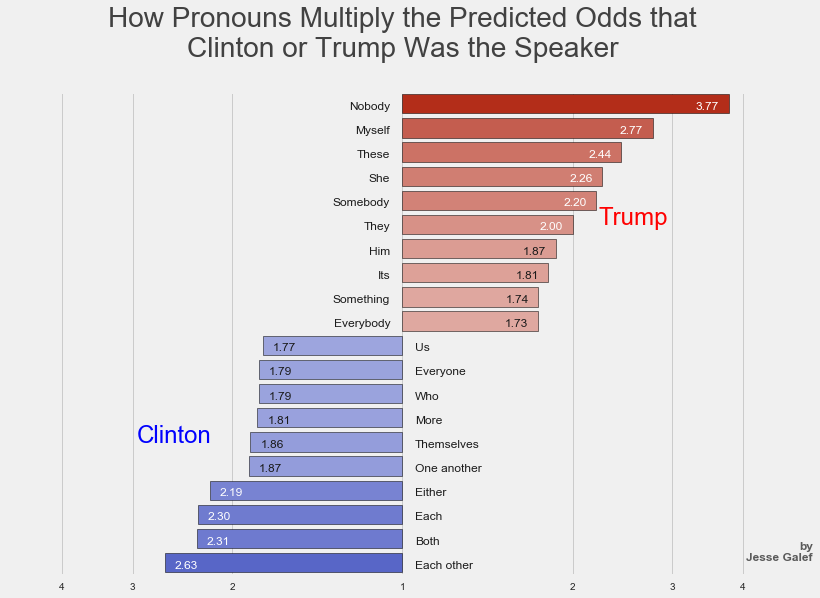

In [503]:
pronoun_coefs = average_coef.loc[[col for col in average_coef.index if col in pronouns]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Trump >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
toplot = pronoun_coefs.iloc[0:10].append(pronoun_coefs.iloc[-10:])

f, (ax1) = plt.subplots(1,1, figsize=(12,9))
label_size = 12
value_size = 9

vals = [np.log(x) for x in toplot.sort_values('Trump', ascending=False).Trump]

#minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]
colors = [color_map(-value/minimum, blue, white) if value < 0 else color_map(value/maximum, red, white) for value in vals]


sns.barplot(x=vals,
            y=toplot.sort_values('Trump', ascending=False).index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_title("How Pronouns Multiply the Predicted Odds that\nClinton or Trump Was the Speaker\n", fontsize=28, color=[.25,.25,.25])

# ax1.set_yticklabels([x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values], fontsize=16)


labels = [x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values]
for i, patch in enumerate(ax1.patches):
    width = patch.get_width()
    
    if patch.get_x() < 0:
        # Bars extending on the left
        label_x = .05
        label_halign = 'left'
        if patch.get_width() >= np.log(1.15):     
            value_x = patch.get_x()+.04
            value_halign = 'left'
        else:
            value_x = patch.get_x()-.04
            value_halign='right'
    else:
        # Bars extending on the right
        label_x = -.05
        label_halign = 'right'
        if patch.get_width() >= np.log(1.15):
            value_x = patch.get_width()-.04
            value_halign = 'right'
        else:
            value_x = patch.get_width() + .04
            value_halign = 'left'

    value_color = [.1,.1,.1]
    if patch.get_width()> np.log(2): value_color = 'white'
    ax1.text(label_x, patch.get_y()+.61, '%s'%(labels[i]), color=[.1,.1,.1], ha=label_halign, fontsize=label_size)   
    ax1.text(value_x, patch.get_y()+.61, '%1.2f'%(np.e**abs(vals[i])), color=value_color, ha=value_halign, fontsize=label_size)    

ax1.text(-np.log(2.95), 14, 'Clinton', color='b', fontsize=24)
ax1.text(np.log(2.95), 5, 'Trump', color='r', fontsize=24, ha='right')

ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_xlim([-np.log(5),np.log(5)])

ax1.set_xticks([-np.log(4),-np.log(3),-np.log(2),0,np.log(2),np.log(3), np.log(4)], minor=False)
ax1.set_xticklabels([4,3,2,1,2,3,4], minor=False)

f.text(.95, .07, 'by\nJesse Galef', color=[.2,.2,.2], fontsize=12, alpha=.8, ha='right', weight='bold', variant='small-caps')


plt.plot()
f.tight_layout(rect=[0,0,.95,.95])

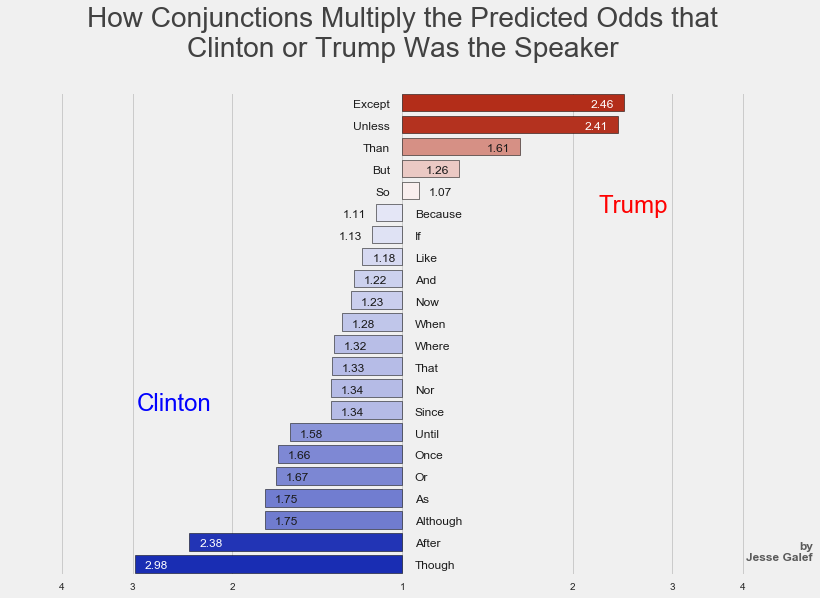

In [504]:
conj_coefs = average_coef.loc[[col for col in average_coef.index if col in conjunctions]].sort_values('Trump', ascending=False)
# toplot = pronoun_coefs[((pronoun_coefs.Truzmp >= 1.5) | (pronoun_coefs.Clinton >=1.5))].copy()
# toplot = conj_coefs.iloc[0:10].append(conj_coefs.iloc[-10:])
toplot = conj_coefs

f, (ax1) = plt.subplots(1,1, figsize=(12,9))
label_size = 12
value_size = 9

vals = [np.log(x) for x in toplot.sort_values('Trump', ascending=False).Trump]

#minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]
colors = [color_map(-value/minimum, blue, white) if value < 0 else color_map(value/maximum, red, white) for value in vals]


sns.barplot(x=vals,
            y=toplot.sort_values('Trump', ascending=False).index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_title("How Conjunctions Multiply the Predicted Odds that\nClinton or Trump Was the Speaker\n", fontsize=28, color=[.25,.25,.25])

# ax1.set_yticklabels([x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values], fontsize=16)


labels = [x[0].upper()+x[1:] for x in toplot.sort_values('Trump', ascending=False).index.values]
for i, patch in enumerate(ax1.patches):
    width = patch.get_width()
    
    if patch.get_x() < 0:
        # Bars extending on the left
        label_x = .05
        label_halign = 'left'
        if patch.get_width() >= np.log(1.15):     
            value_x = patch.get_x()+.04
            value_halign = 'left'
        else:
            value_x = patch.get_x()-.04
            value_halign='right'
    else:
        # Bars extending on the right
        label_x = -.05
        label_halign = 'right'
        if patch.get_width() >= np.log(1.15):
            value_x = patch.get_width()-.04
            value_halign = 'right'
        else:
            value_x = patch.get_width() + .04
            value_halign = 'left'

    value_color = [.1,.1,.1]
    if patch.get_width()> np.log(2): value_color = 'white'
    ax1.text(label_x, patch.get_y()+.61, '%s'%(labels[i]), color=[.1,.1,.1], ha=label_halign, fontsize=label_size)   
    ax1.text(value_x, patch.get_y()+.61, '%1.2f'%(np.e**abs(vals[i])), color=value_color, ha=value_halign, fontsize=label_size)    

ax1.text(-np.log(2.95), 14, 'Clinton', color='b', fontsize=24)
ax1.text(np.log(2.95), 5, 'Trump', color='r', fontsize=24, ha='right')

ax1.set_yticklabels([])
ax1.set_xlabel('')
ax1.set_xlim([-np.log(5),np.log(5)])

ax1.set_xticks([-np.log(4),-np.log(3),-np.log(2),0,np.log(2),np.log(3), np.log(4)], minor=False)
ax1.set_xticklabels([4,3,2,1,2,3,4], minor=False)

f.text(.95, .07, 'by\nJesse Galef', color=[.2,.2,.2], fontsize=12, alpha=.8, ha='right', weight='bold', variant='small-caps')


plt.plot()
f.tight_layout(rect=[0,0,.95,.95])

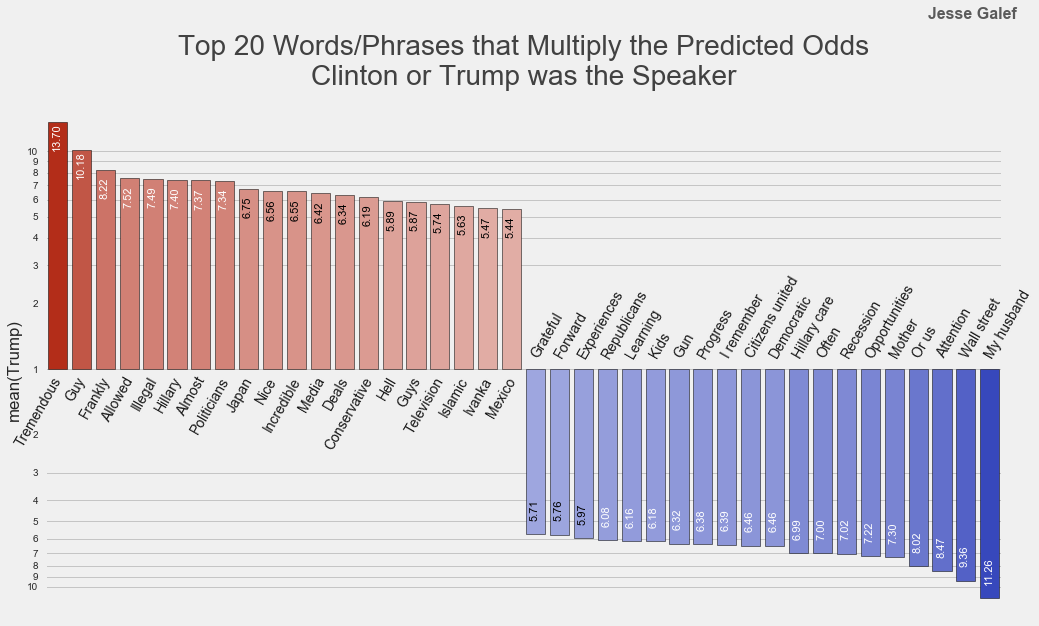

In [505]:
#  seaborn.barplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None, 
#  estimator=<function mean>, ci=95, n_boot=1000, units=None, orient=None, color=None,
#  palette=None, saturation=0.75, errcolor='.26', errwidth=None, capsize=None, ax=None, **kwargs)¶
f, ax1 = plt.subplots(1,1, figsize=(15,9))

ax1.set_yticks([-1*np.log(x) for x in range(10,1,-1)]+[0]+[np.log(y) for y in range(2,11)])
    
ax1.set_yticklabels(range(10,1,-1)+['1']+range(2,11))


ax1.set_ylabel('')

label_font_size = 14
value_font_size=11
rotate =60
n_words = 20

color_adjustment = np.log(3)
val_series = average_coef.sort_values('Trump', ascending=False)['Trump']
vals = val_series[:n_words].append(val_series[-n_words:])
vals = np.log(vals)

# minimum=abs(min(vals))
maximum=max(vals)
minimum=maximum
blue=[0,.1,.8]
red = [.8,.1,0]
white = [1,1,1]

colors = [color_map(-(value+color_adjustment)/(minimum-color_adjustment), blue, white) if value < 0 else color_map((value-color_adjustment)/(maximum-color_adjustment), red, white) for value in vals]

sns.barplot(y=vals,
            x=vals.index, ax=ax1,
            palette=colors, 
#             color=colors,
            edgecolor='black')

ax1.set_xticks([])
ax1.set_xlabel('')
ax1.set_title("Top "+str(n_words)+" Words/Phrases that Multiply the Predicted Odds\nClinton or Trump was the Speaker\n", fontsize=28, color=[.25,.25,.25])


labels = [x[0].upper()+x[1:] for x in vals.sort_values(ascending=False).index.values]

for i, patch in enumerate(ax1.patches):
    height = patch.get_height()
    if patch.get_y() < 0:
#         y = patch.get_y() -.5
        if height > np.log(6): 
            color = 'white'
        else:
            color = 'black'

        ax1.text(patch.get_x()+.1, .1, '%s'%(labels[i]), color=[.1,.1,.1], va='bottom', ha='left', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+.15, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation=90, va='bottom', fontsize=value_font_size)
    else:
        if height > np.log(7): 
            color = 'white'
        else:
            color = 'black'
        ax1.text(patch.get_x()+.7, -.05, '%s'%(labels[i]), color=[.1,.1,.1], ha='right', va='top', rotation=rotate, fontsize=label_font_size)
        ax1.text(patch.get_x()+.15, patch.get_y()+height-.3, '%1.2f'%(np.e**abs(vals[i])), color=color, rotation = 90, va='bottom', fontsize=value_font_size)

            
f.text(.95, .95, 'Jesse Galef', color=[.2,.2,.2], fontsize=16, alpha=.8, ha='right', weight='bold', variant='small-caps')

ax1.set_ylim([-np.log(14), np.log(14)])

# ax1.yaxis.tick_right()
# ax1.yaxis.set_ticks_position('both')

for i, ygrid in enumerate(ax1.get_ygridlines()):
#     print ygrid.get_ydata(orig=False)[0], np.log(2)
#     if abs(ygrid.get_ydata(orig=True)[0]) == np.log(2):
    if i==8 or i==10:
        ygrid.set_xdata([0,0])

plt.grid(which='major', color=[.7,.7,.7], alpha=.7)
plt.margins(.3)
plt.plot()
f.tight_layout(rect=[0,0,.95,.95])



In [572]:
print average_coef.loc['believe']
print average_coef.loc['believe me']
print average_coef.loc['obama']
print average_coef.loc['president obama']
print average_coef.loc['bernie']
print average_coef.loc['senator sanders']
print average_coef.loc['muslims']
print average_coef.loc['the muslims']
# muslims vs the muslims
# believe me vs believe them (cheap)

Clinton    1.173858
Trump      0.851892
Name: believe, dtype: float64
Clinton    0.260293
Trump      3.841824
Name: believe me, dtype: float64
Clinton    0.187887
Trump      5.322339
Name: obama, dtype: float64
Clinton    3.876268
Trump      0.257980
Name: president obama, dtype: float64
Clinton    0.267514
Trump      3.738117
Name: bernie, dtype: float64
Clinton    3.009256
Trump      0.332308
Name: senator sanders, dtype: float64
Clinton    3.922111
Trump      0.254965
Name: muslims, dtype: float64
Clinton    0.520325
Trump      1.921877
Name: the muslims, dtype: float64


In [513]:
print average_coef.loc['avg_word_length']
print average_coef.loc['num_words']
print average_coef.loc['num_words_sqrt']


Clinton    1.423100
Trump      0.702691
Name: avg_word_length, dtype: float64
Clinton    0.974539
Trump      1.026127
Name: num_words, dtype: float64
Clinton    1.257456
Trump      0.795256
Name: num_words_sqrt, dtype: float64


In [588]:
word = 'myself'
# word_in_term = [word in re.findall(regex_token_pattern,term) for term in average_coef.index]
word_in_term = [word in term for term in average_coef.index]

average_coef[word_in_term]

,Clinton,Trump
myself,0.360461,2.774224
